<a href="https://colab.research.google.com/github/miczkejedrzej/MNLP-project-1/blob/main/Data_collection_Country_P17_P27_P495.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# Import of the training data

from google.colab import files
uploaded = files.upload()

# Import of moduls

!pip install wikidata --quiet

import matplotlib.pyplot as plt
import pandas as pd
from wikidata.client import Client

from tqdm.auto import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading the data
train_df = pd.read_csv('[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep='\t')

Saving [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv to [MNLP 2025 HW1] train set [PUBLIC] - train_cleaned (1).tsv


In [153]:
train_df = pd.read_csv('[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep='\t')

In [156]:
for category in ['cultural exclusive', 'cultural representative', 'cultural agnostic']:
  print(f'sum of entries for category {category} is  {train_df[train_df["label"] == category].shape[0]}')

sum of entries for category cultural exclusive is  2685
sum of entries for category cultural representative is  1685
sum of entries for category cultural agnostic is  1862


In [78]:
def extract_entity_id(url):
    return url.strip().split("/")[-1]

In [79]:
def get_claims(wikidata_url):
  # Extract the id of the item
    entity_id = extract_entity_id(wikidata_url)

    # Extract information of the item
    client = Client()
    item = client.get(entity_id, load=True)

    # Extract the claims of the item
    claims = item.data.get("claims", {})

    return claims

In [182]:
def get_country(wikidata_url):

    claims = get_claims(wikidata_url)
    client = Client()

    country_of_origin_name = None
    country_name = None
    nationality_name = None

    # Extract the statement "P495" : Country of origin
    unicode_statements = claims.get("P495", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})


            country_of_origin_id = value.get("id")
            try:
              country_of_origin_entity = client.get(country_of_origin_id, load=True)
              country_of_origin_name = country_of_origin_entity.label
            except:
              return country_of_origin_name, None, None

            return country_of_origin_name, country_name, nationality_name


    # Extract the statement "P17" : Country
    unicode_statements = claims.get("P17", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            country_id = value.get("id")
            try:
              country_entity = client.get(country_id, load=True)
              country_name = country_entity.label
            except:
              return country_id, None, None
            #country_entity = client.get(country_id, load=True)

            return country_of_origin_name, country_name, nationality_name


    # Extract the statement "P27" : Nationality
    unicode_statements = claims.get("P27", [])
    if unicode_statements:
        for statement in unicode_statements:
            mainsnak = statement.get("mainsnak", {})
            datavalue = mainsnak.get("datavalue", {})
            value = datavalue.get("value", {})
            nationality_id = value.get("id")
            try:
              nationality_entity = client.get(nationality_id, load=True)
              nationality_name = nationality_entity.label
            except:
              return nationality_id, None, None


    return country_of_origin_name, country_name, nationality_name


# Test on one line of the DataFrame
#wikidata_url = train_df.iloc[532, 0]
#get_country(wikidata_url)

In [183]:
# We merge the variables, in order to have only one.

def merge_variables(df, variables):
  """
  Take in input, the variables of a dataframe, and return a dataframe with a single variable => the first value founded across the rows
  """
  return df[variables].bfill(axis=1).iloc[:, 0]

In [179]:
train_df = pd.read_csv('[MNLP 2025 HW1] train set [PUBLIC] - train_cleaned.tsv', sep='\t')

In [184]:
# Apply the function to a subset of the DataFrame
def add_country_information(df,lower_bound=10,upper_bound=100,category =None):
  df = df.sample(frac=1).reset_index(drop=True)
  subset = range(lower_bound,upper_bound)
  if category is not None:
    df = df[(df['label'] == category)]
  #df = df[(df['label'] == 'cultural exclusive')]
    df.reset_index(drop=True, inplace=True)
  country_informations = df.loc[subset, "item"].apply(lambda url: get_country(url))


  variables = ['country_of_origin_id', 'country_id', 'nationality_id']
  country_informations_df = pd.DataFrame(country_informations.tolist(), columns=variables)


  # We merge the variables, in order to have only one
  country_informations_df['country'] = merge_variables(country_informations_df, variables)
  country_informations_df.drop(variables, axis=1, inplace=True)

  # We add the new variable to the training dataset
  df.loc[subset, 'country'] = country_informations_df['country'].values


  df.iloc[lower_bound:upper_bound, df.columns.get_loc('country')] = country_informations_df['country'].values


  return df

  0%|          | 0/3 [00:00<?, ?it/s]

 the ratio of the entries with the country information to all entries 
 in randomaly choosen sample of 200 records with labels: cultural exclusive is 0.15


 the ratio of the entries with the country information to all entries 
 in randomaly choosen sample of 200 records with labels: cultural representative is 0.34


 the ratio of the entries with the country information to all entries 
 in randomaly choosen sample of 200 records with labels: cultural agnostic is 0.9




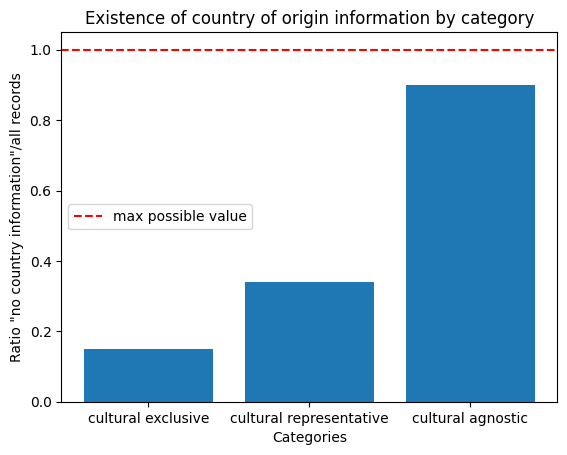

In [185]:
#
lower_bound = 0
upper_bound = 200
subset = range(lower_bound,upper_bound)
total = upper_bound - lower_bound
nan_counts = []
categories = ['cultural exclusive', 'cultural representative', 'cultural agnostic']
for i in tqdm(range(len(categories))):
  enriched_train_df = add_country_information(train_df,lower_bound,upper_bound,categories[i])
  nan_ratio = enriched_train_df.loc[subset,'country'].isna().sum()/total
  nan_counts.append(nan_ratio)


for i in range(len(categories)):
    print(f' the ratio of the entries with the country information to all entries \n in randomaly choosen sample of {upper_bound-lower_bound} records with labels: {categories[i]} is {nan_counts[i]}')
    print('\n')


# Total rows in the subset

import matplotlib.pyplot as plt

# Sample data

# Create bar chart
plt.bar(categories, nan_counts)
plt.title('Existence of country of origin information by category')
plt.xlabel('Categories')
plt.ylabel('Ratio "no country information"/all records')
plt.axline((0, 1), slope=0, color='red', linestyle='--',label = 'max possible value')
plt.legend()
plt.show()


